# 🎯 Face Recognition Pipeline dengan MobileFaceNet + LFW Pretraining

## Pipeline Overview
1. **LFW Pretraining** - Pretrain backbone pada ~13,000 gambar LFW untuk robust face embeddings
2. **Transfer Learning** - Freeze backbone, fine-tune head untuk 2 kelas (Naufal, Ryan)
3. **Feature Extraction + SVM** - Extract embeddings → train SVM classifier
4. **TFLite Export** - Konversi untuk Android deployment

## Strategi untuk Dataset Kecil (~100 gambar)
- ✅ LFW pretraining untuk robust base features
- ✅ Freeze backbone (menghindari overfitting)
- ✅ Data augmentation yang aman untuk wajah
- ✅ SVM classifier (tidak memerlukan banyak data)
- ✅ ArcFace loss dengan margin konservatif

In [ ]:
# ============================================
# CELL 1: Install & Import Dependencies
# ============================================
%pip install tensorflow opencv-python scikit-learn pillow matplotlib tqdm -q

In [1]:
# ============================================
# CELL 2: Import Libraries
# ============================================
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# GPU Memory Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ GPU detected: {len(gpus)} device(s)")
else:
    print("⚠️ No GPU detected, using CPU")

print(f"TensorFlow version: {tf.__version__}")

⚠️ No GPU detected, using CPU
TensorFlow version: 2.18.0


## 📐 Section 1: MobileFaceNet Architecture

MobileFaceNet adalah arsitektur lightweight untuk face recognition yang optimal untuk mobile deployment.

**Karakteristik:**
- Input: 112×112×3 (RGB)
- Embedding: 128-dim (akan dikurangi ke 64 untuk dataset kecil)
- ~1M parameters
- Menggunakan Depthwise Separable Convolutions
- Global Depthwise Convolution (GDC) untuk pooling

In [2]:
# ============================================
# CELL 3: MobileFaceNet Architecture
# ============================================

def conv_bn_prelu(x, filters, kernel_size, strides=1, padding='same', name=None):
    """Conv + BatchNorm + PReLU block"""
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding,
                      use_bias=False, kernel_regularizer=regularizers.l2(1e-4),
                      name=f'{name}_conv' if name else None)(x)
    x = layers.BatchNormalization(name=f'{name}_bn' if name else None)(x)
    x = layers.PReLU(shared_axes=[1, 2], name=f'{name}_prelu' if name else None)(x)
    return x

def depthwise_separable_conv(x, filters, strides=1, name=None):
    """Depthwise Separable Convolution block"""
    x = layers.DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False,
                                depthwise_regularizer=regularizers.l2(1e-4),
                                name=f'{name}_dw' if name else None)(x)
    x = layers.BatchNormalization(name=f'{name}_dw_bn' if name else None)(x)
    x = layers.PReLU(shared_axes=[1, 2], name=f'{name}_dw_prelu' if name else None)(x)
    x = layers.Conv2D(filters, 1, use_bias=False, kernel_regularizer=regularizers.l2(1e-4),
                      name=f'{name}_pw' if name else None)(x)
    x = layers.BatchNormalization(name=f'{name}_pw_bn' if name else None)(x)
    x = layers.PReLU(shared_axes=[1, 2], name=f'{name}_pw_prelu' if name else None)(x)
    return x

def bottleneck(x, filters, strides=1, expansion=2, name=None):
    """Inverted Residual Bottleneck block"""
    in_channels = x.shape[-1]
    expanded_channels = in_channels * expansion
    
    # Expansion
    residual = layers.Conv2D(expanded_channels, 1, use_bias=False,
                              kernel_regularizer=regularizers.l2(1e-4),
                              name=f'{name}_expand' if name else None)(x)
    residual = layers.BatchNormalization(name=f'{name}_expand_bn' if name else None)(residual)
    residual = layers.PReLU(shared_axes=[1, 2], name=f'{name}_expand_prelu' if name else None)(residual)
    
    # Depthwise
    residual = layers.DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False,
                                       depthwise_regularizer=regularizers.l2(1e-4),
                                       name=f'{name}_dw' if name else None)(residual)
    residual = layers.BatchNormalization(name=f'{name}_dw_bn' if name else None)(residual)
    residual = layers.PReLU(shared_axes=[1, 2], name=f'{name}_dw_prelu' if name else None)(residual)
    
    # Projection
    residual = layers.Conv2D(filters, 1, use_bias=False,
                              kernel_regularizer=regularizers.l2(1e-4),
                              name=f'{name}_project' if name else None)(residual)
    residual = layers.BatchNormalization(name=f'{name}_project_bn' if name else None)(residual)
    
    # Skip connection (only if same shape)
    if strides == 1 and in_channels == filters:
        return layers.Add(name=f'{name}_add' if name else None)([x, residual])
    return residual

def build_mobilefacenet(input_shape=(112, 112, 3), embedding_size=128, dropout_rate=0.3):
    """
    Build MobileFaceNet backbone
    
    Args:
        input_shape: Input image shape (112, 112, 3)
        embedding_size: Output embedding dimension
        dropout_rate: Dropout rate for regularization
    
    Returns:
        Keras Model outputting L2-normalized embeddings
    """
    inputs = layers.Input(shape=input_shape, name='input_image')
    
    # Initial conv
    x = conv_bn_prelu(inputs, 64, 3, strides=2, name='conv1')  # 56x56
    
    # Depthwise separable conv
    x = depthwise_separable_conv(x, 64, name='dw_conv1')  # 56x56
    
    # Bottleneck blocks
    # Stage 1: 56x56 -> 28x28
    x = bottleneck(x, 64, strides=2, expansion=2, name='bottleneck1_1')
    x = bottleneck(x, 64, strides=1, expansion=2, name='bottleneck1_2')
    x = bottleneck(x, 64, strides=1, expansion=2, name='bottleneck1_3')
    x = bottleneck(x, 64, strides=1, expansion=2, name='bottleneck1_4')
    x = bottleneck(x, 64, strides=1, expansion=2, name='bottleneck1_5')
    
    # Stage 2: 28x28 -> 14x14
    x = bottleneck(x, 128, strides=2, expansion=4, name='bottleneck2_1')
    
    # Stage 3: 14x14 -> 7x7
    x = bottleneck(x, 128, strides=2, expansion=2, name='bottleneck3_1')
    x = bottleneck(x, 128, strides=1, expansion=2, name='bottleneck3_2')
    x = bottleneck(x, 128, strides=1, expansion=2, name='bottleneck3_3')
    x = bottleneck(x, 128, strides=1, expansion=2, name='bottleneck3_4')
    x = bottleneck(x, 128, strides=1, expansion=2, name='bottleneck3_5')
    x = bottleneck(x, 128, strides=1, expansion=2, name='bottleneck3_6')
    
    # 1x1 conv to expand channels
    x = conv_bn_prelu(x, 512, 1, name='conv2')  # 7x7x512
    
    # Global Depthwise Convolution (GDC) - replaces global pooling
    x = layers.DepthwiseConv2D(7, padding='valid', use_bias=False,
                                depthwise_regularizer=regularizers.l2(1e-4),
                                name='gdc')(x)  # 1x1x512
    x = layers.BatchNormalization(name='gdc_bn')(x)
    
    # Flatten and embedding
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(dropout_rate, name='dropout')(x)
    x = layers.Dense(embedding_size, use_bias=False,
                     kernel_regularizer=regularizers.l2(1e-4),
                     name='embedding_dense')(x)
    x = layers.BatchNormalization(name='embedding_bn')(x)
    
    # L2 normalize embeddings
    embeddings = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), 
                               name='l2_normalize')(x)
    
    model = Model(inputs, embeddings, name='MobileFaceNet')
    return model

# Test model creation
test_model = build_mobilefacenet(embedding_size=128)
print(f"✅ MobileFaceNet created successfully")
print(f"   Total parameters: {test_model.count_params():,}")
print(f"   Input shape: {test_model.input_shape}")
print(f"   Output shape: {test_model.output_shape}")
del test_model


✅ MobileFaceNet created successfully
   Total parameters: 744,000
   Input shape: (None, 112, 112, 3)
   Output shape: (None, 128)


In [3]:
# ============================================
# CELL 4: ArcFace Loss Layer
# ============================================

class ArcFaceLayer(layers.Layer):
    """
    ArcFace loss implementation untuk margin-based face recognition
    
    Formula: cos(θ + m) dengan angular margin m
    
    Parameters untuk dataset kecil:
    - scale (s): 32 (dikurangi dari 64 untuk menghindari overconfidence)
    - margin (m): 0.3 (dikurangi dari 0.5 untuk decision boundary yang lebih toleran)
    """
    def __init__(self, num_classes, scale=32.0, margin=0.3, **kwargs):
        super(ArcFaceLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.scale = scale
        self.margin = margin
        
    def build(self, input_shape):
        self.W = self.add_weight(
            name='arcface_weights',
            shape=(input_shape[-1], self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )
        super().build(input_shape)
        
    def call(self, embeddings, labels=None, training=None):
        # Normalize weights
        W_norm = tf.math.l2_normalize(self.W, axis=0)
        
        # Cosine similarity: embeddings sudah L2-normalized
        cosine = tf.matmul(embeddings, W_norm)
        
        if training and labels is not None:
            # Add angular margin
            theta = tf.acos(tf.clip_by_value(cosine, -1.0 + 1e-7, 1.0 - 1e-7))
            
            # One-hot encoding
            one_hot = tf.one_hot(labels, depth=self.num_classes)
            
            # Add margin hanya pada target class
            target_logits = tf.cos(theta + self.margin)
            cosine = cosine * (1 - one_hot) + target_logits * one_hot
        
        # Scale logits
        return cosine * self.scale
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_classes': self.num_classes,
            'scale': self.scale,
            'margin': self.margin
        })
        return config

print("✅ ArcFaceLayer defined")

✅ ArcFaceLayer defined


## 👤 Section 2: Face Detection & Preprocessing

Menggunakan OpenCV DNN (SSD MobileNet) untuk face detection yang cepat dan akurat.

In [4]:
# ============================================
# CELL 5: Face Detector Class
# ============================================

class FaceDetector:
    """
    Face detection using OpenCV DNN (SSD MobileNet)
    
    Pipeline:
    1. Detect face dengan confidence threshold
    2. Crop dengan margin (20%)
    3. Resize ke 112x112
    4. Normalize ke [-1, 1]
    """
    
    def __init__(self, confidence_threshold=0.7):
        self.confidence_threshold = confidence_threshold
        self.net = None
        self._load_model()
        
    def _load_model(self):
        """Load OpenCV DNN face detector"""
        model_dir = 'models'
        os.makedirs(model_dir, exist_ok=True)
        
        prototxt_path = os.path.join(model_dir, 'deploy.prototxt')
        caffemodel_path = os.path.join(model_dir, 'res10_300x300_ssd_iter_140000.caffemodel')
        
        # Download jika belum ada
        if not os.path.exists(prototxt_path):
            print("📥 Downloading face detector prototxt...")
            import urllib.request
            url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
            urllib.request.urlretrieve(url, prototxt_path)
            
        if not os.path.exists(caffemodel_path):
            print("📥 Downloading face detector model...")
            import urllib.request
            url = "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"
            urllib.request.urlretrieve(url, caffemodel_path)
        
        self.net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)
        print("✅ Face detector loaded")
        
    def detect_faces(self, image):
        """
        Detect all faces in image
        
        Args:
            image: BGR image (OpenCV format)
            
        Returns:
            List of (x, y, w, h, confidence) tuples
        """
        h, w = image.shape[:2]
        blob = cv2.dnn.blobFromImage(
            cv2.resize(image, (300, 300)), 
            1.0, (300, 300), 
            (104.0, 177.0, 123.0)
        )
        
        self.net.setInput(blob)
        detections = self.net.forward()
        
        faces = []
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > self.confidence_threshold:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                x1, y1, x2, y2 = box.astype(int)
                faces.append((x1, y1, x2 - x1, y2 - y1, confidence))
        
        return faces
    
    def crop_face(self, image, face_box, margin=0.2, target_size=(112, 112)):
        """
        Crop and preprocess face from image
        
        Args:
            image: BGR image
            face_box: (x, y, w, h, confidence)
            margin: Margin around face (20% recommended)
            target_size: Output size (112x112 for MobileFaceNet)
            
        Returns:
            Cropped and preprocessed face image (RGB, normalized to [-1, 1])
        """
        x, y, w, h, _ = face_box
        img_h, img_w = image.shape[:2]
        
        # Add margin
        margin_w = int(w * margin)
        margin_h = int(h * margin)
        
        x1 = max(0, x - margin_w)
        y1 = max(0, y - margin_h)
        x2 = min(img_w, x + w + margin_w)
        y2 = min(img_h, y + h + margin_h)
        
        # Crop face
        face = image[y1:y2, x1:x2]
        
        # Resize to target size
        face = cv2.resize(face, target_size)
        
        # BGR to RGB
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        
        return face
    
    def preprocess_for_model(self, face_image):
        """
        Normalize face image untuk MobileFaceNet
        
        Args:
            face_image: RGB image [0, 255]
            
        Returns:
            Normalized image [-1, 1]
        """
        return (face_image.astype(np.float32) / 127.5) - 1.0
    
    def extract_face(self, image):
        """
        Complete pipeline: detect → crop → preprocess
        
        Returns:
            Preprocessed face atau None jika tidak ada wajah
        """
        faces = self.detect_faces(image)
        if not faces:
            return None
        
        # Ambil wajah dengan confidence tertinggi
        best_face = max(faces, key=lambda x: x[4])
        face_crop = self.crop_face(image, best_face)
        return self.preprocess_for_model(face_crop)

# Initialize detector
face_detector = FaceDetector(confidence_threshold=0.5)
print("✅ FaceDetector initialized")

✅ Face detector loaded
✅ FaceDetector initialized


## 📚 Section 3: LFW Dataset Loading & Pretraining

**Strategi LFW Pretraining:**
1. Load semua orang yang memiliki ≥ 5 gambar (untuk cukup variasi)
2. Extract face dengan detector
3. Train backbone dengan ArcFace loss
4. Save pretrained weights untuk transfer learning

Ini akan memberikan backbone yang sudah "mengerti" fitur wajah sebelum fine-tune ke dataset kecil (Naufal, Ryan).

In [5]:
# ============================================
# CELL 6: Load LFW Dataset
# ============================================

def load_lfw_dataset(lfw_dir='lfw_funneled', min_images_per_person=10, max_persons=500, max_images_per_person=20):
    """
    Load LFW dataset untuk pretraining
    
    Args:
        lfw_dir: Path ke LFW dataset
        min_images_per_person: Minimum gambar per orang (filter orang dengan sedikit gambar)
        max_persons: Maximum jumlah orang untuk pretraining
        max_images_per_person: Maximum gambar per orang (balance classes)
        
    Returns:
        images: List of face images
        labels: List of person indices
        label_names: List of person names
    """
    print(f"📂 Loading LFW dataset from {lfw_dir}...")
    
    # Get all person directories
    person_dirs = []
    for person_name in os.listdir(lfw_dir):
        person_path = os.path.join(lfw_dir, person_name)
        if os.path.isdir(person_path):
            images_in_folder = [f for f in os.listdir(person_path) if f.endswith('.jpg')]
            if len(images_in_folder) >= min_images_per_person:
                person_dirs.append((person_name, person_path, len(images_in_folder)))
    
    # Sort by number of images and take top N
    person_dirs.sort(key=lambda x: x[2], reverse=True)
    person_dirs = person_dirs[:max_persons]
    
    print(f"📊 Found {len(person_dirs)} persons with ≥{min_images_per_person} images")
    
    images = []
    labels = []
    label_names = [p[0] for p in person_dirs]
    
    for idx, (person_name, person_path, _) in enumerate(tqdm(person_dirs, desc="Loading faces")):
        image_files = [f for f in os.listdir(person_path) if f.endswith('.jpg')][:max_images_per_person]
        
        for img_file in image_files:
            img_path = os.path.join(person_path, img_file)
            try:
                # Load image
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                # Detect and crop face
                face = face_detector.extract_face(img)
                if face is not None:
                    images.append(face)
                    labels.append(idx)
            except Exception as e:
                continue
    
    print(f"✅ Loaded {len(images)} face images from {len(label_names)} persons")
    return np.array(images), np.array(labels), label_names

# Load LFW data (menggunakan subset untuk efisiensi)
lfw_images, lfw_labels, lfw_names = load_lfw_dataset(
    lfw_dir='lfw_funneled',
    min_images_per_person=10,
    max_persons=200,  # 200 orang teratas
    max_images_per_person=30
)

print(f"\n📈 LFW Dataset Statistics:")
print(f"   Total images: {len(lfw_images)}")
print(f"   Total classes: {len(lfw_names)}")
print(f"   Image shape: {lfw_images[0].shape}")

📂 Loading LFW dataset from lfw_funneled...
📊 Found 158 persons with ≥10 images


Loading faces: 100%|██████████| 158/158 [05:01<00:00,  1.91s/it]


✅ Loaded 2974 face images from 158 persons

📈 LFW Dataset Statistics:
   Total images: 2974
   Total classes: 158
   Image shape: (112, 112, 3)


In [6]:
# ============================================
# CELL 7: Data Augmentation untuk Pretraining
# ============================================

def create_augmentation_layer():
    """
    Data augmentation yang AMAN untuk wajah
    
    Yang digunakan:
    - Horizontal flip (wajah simetris)
    - Rotasi kecil (±10°) - simulasi head tilt
    - Brightness (±20%) - variasi lighting
    - Contrast (±20%) - variasi kamera
    
    Yang TIDAK digunakan:
    - Vertical flip (tidak natural)
    - Zoom besar (kehilangan fitur)
    - Shearing (distorsi wajah)
    """
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.03),  # ~10 degrees
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
    ], name='augmentation')

augmentation = create_augmentation_layer()
print("✅ Augmentation layer created")

✅ Augmentation layer created


In [7]:
# ============================================
# CELL 8: Build Training Model dengan ArcFace
# ============================================

def build_training_model(backbone, num_classes, arcface_scale=32.0, arcface_margin=0.3):
    """
    Build training model dengan ArcFace head
    
    Architecture:
    Input → Augmentation → MobileFaceNet → ArcFace → Softmax
    
    Args:
        backbone: MobileFaceNet backbone
        num_classes: Jumlah orang dalam dataset
        arcface_scale: Scale parameter (32 untuk dataset kecil)
        arcface_margin: Angular margin (0.3 untuk dataset kecil)
    """
    inputs = keras.Input(shape=(112, 112, 3), name='image')
    labels = keras.Input(shape=(), dtype=tf.int32, name='label')
    
    # Augmentation (hanya saat training)
    x = augmentation(inputs)
    
    # Get embeddings from backbone
    embeddings = backbone(x)
    
    # ArcFace classification head
    arcface = ArcFaceLayer(num_classes, scale=arcface_scale, margin=arcface_margin, name='arcface')
    logits = arcface(embeddings, labels, training=True)
    
    # Build model
    model = Model(inputs=[inputs, labels], outputs=logits, name='TrainingModel')
    return model

# Create backbone for pretraining
print("🔧 Building MobileFaceNet backbone for LFW pretraining...")
lfw_backbone = build_mobilefacenet(input_shape=(112, 112, 3), embedding_size=128, dropout_rate=0.3)

# Create training model
lfw_num_classes = len(lfw_names)
lfw_training_model = build_training_model(
    backbone=lfw_backbone,
    num_classes=lfw_num_classes,
    arcface_scale=64.0,  # Scale lebih besar untuk LFW (dataset lebih besar)
    arcface_margin=0.5   # Margin standar untuk LFW
)

print(f"✅ LFW Training model built")
print(f"   Number of classes: {lfw_num_classes}")
print(f"   Total parameters: {lfw_training_model.count_params():,}")

🔧 Building MobileFaceNet backbone for LFW pretraining...
✅ LFW Training model built
   Number of classes: 158
   Total parameters: 764,224


In [8]:
# ============================================
# CELL 9: Custom Training Loop untuk ArcFace
# ============================================

class ArcFaceTrainer:
    """
    Custom trainer untuk ArcFace training
    
    Training configuration:
    - Optimizer: AdamW dengan weight decay
    - Learning rate: Cosine annealing
    - Gradient clipping: norm=5.0
    - Early stopping: patience=10
    """
    
    def __init__(self, model, backbone, learning_rate=1e-3, weight_decay=1e-4):
        self.model = model
        self.backbone = backbone
        self.optimizer = keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=weight_decay
        )
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        
        # Metrics
        self.train_loss = keras.metrics.Mean(name='train_loss')
        self.train_acc = keras.metrics.SparseCategoricalAccuracy(name='train_acc')
        self.val_loss = keras.metrics.Mean(name='val_loss')
        self.val_acc = keras.metrics.SparseCategoricalAccuracy(name='val_acc')
        
    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            logits = self.model([images, labels], training=True)
            loss = self.loss_fn(labels, logits)
            
        # Compute gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Clip gradients
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        # Update metrics
        self.train_loss.update_state(loss)
        self.train_acc.update_state(labels, logits)
        
        return loss
    
    @tf.function
    def val_step(self, images, labels):
        logits = self.model([images, labels], training=False)
        loss = self.loss_fn(labels, logits)
        
        self.val_loss.update_state(loss)
        self.val_acc.update_state(labels, logits)
        
        return loss
    
    def fit(self, train_data, val_data, epochs=30, patience=10, save_path='models/lfw_pretrained.weights.h5'):
        """
        Train model dengan early stopping
        """
        best_val_acc = 0
        patience_counter = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        
        for epoch in range(epochs):
            # Reset metrics
            self.train_loss.reset_state()
            self.train_acc.reset_state()
            self.val_loss.reset_state()
            self.val_acc.reset_state()
            
            # Training
            for batch_images, batch_labels in train_data:
                self.train_step(batch_images, batch_labels)
            
            # Validation
            for batch_images, batch_labels in val_data:
                self.val_step(batch_images, batch_labels)
            
            # Get metrics
            train_loss = self.train_loss.result().numpy()
            train_acc = self.train_acc.result().numpy()
            val_loss = self.val_loss.result().numpy()
            val_acc = self.val_acc.result().numpy()
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
                  f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
            
            # Early stopping check
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Save best backbone weights
                self.backbone.save_weights(save_path)
                print(f"   ✅ Best model saved (val_acc: {val_acc:.4f})")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"⚠️ Early stopping at epoch {epoch+1}")
                    break
        
        # Load best weights
        self.backbone.load_weights(save_path)
        print(f"\n✅ Training complete. Best val_acc: {best_val_acc:.4f}")
        
        return history

print("✅ ArcFaceTrainer defined")

✅ ArcFaceTrainer defined


In [9]:
# ============================================
# CELL 10: Run LFW Pretraining
# ============================================

# Split LFW data
X_train_lfw, X_val_lfw, y_train_lfw, y_val_lfw = train_test_split(
    lfw_images, lfw_labels, 
    test_size=0.15, 
    stratify=lfw_labels, 
    random_state=42
)

print(f"📊 LFW Data Split:")
print(f"   Train: {len(X_train_lfw)} images")
print(f"   Val: {len(X_val_lfw)} images")

# Create tf.data datasets
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds_lfw = tf.data.Dataset.from_tensor_slices((X_train_lfw, y_train_lfw))
train_ds_lfw = train_ds_lfw.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds_lfw = tf.data.Dataset.from_tensor_slices((X_val_lfw, y_val_lfw))
val_ds_lfw = val_ds_lfw.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"✅ TF Dataset created")

📊 LFW Data Split:
   Train: 2527 images
   Val: 447 images
✅ TF Dataset created


In [10]:
# ============================================
# CELL 11: Train LFW (atau load pretrained)
# ============================================

PRETRAINED_PATH = 'models/lfw_pretrained.weights.h5'
TRAIN_LFW = not os.path.exists(PRETRAINED_PATH)  # Train jika belum ada

if TRAIN_LFW:
    print("🚀 Starting LFW Pretraining...")
    print("   This will take 15-30 minutes depending on your hardware.")
    print("=" * 60)
    
    # Create trainer
    trainer = ArcFaceTrainer(
        model=lfw_training_model,
        backbone=lfw_backbone,
        learning_rate=1e-3,
        weight_decay=1e-4
    )
    
    # Train
    history = trainer.fit(
        train_data=train_ds_lfw,
        val_data=val_ds_lfw,
        epochs=30,
        patience=10,
        save_path=PRETRAINED_PATH
    )
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('models/lfw_training_history.png', dpi=150)
    plt.show()
    
else:
    print(f"📥 Loading pretrained weights from {PRETRAINED_PATH}")
    lfw_backbone.load_weights(PRETRAINED_PATH)
    print("✅ Pretrained weights loaded successfully")

# Verify backbone works
test_input = np.random.randn(1, 112, 112, 3).astype(np.float32)
test_embedding = lfw_backbone.predict(test_input, verbose=0)
print(f"✅ Backbone output shape: {test_embedding.shape}")
print(f"   Embedding L2 norm: {np.linalg.norm(test_embedding):.4f} (should be ~1.0)")

🚀 Starting LFW Pretraining...
   This will take 15-30 minutes depending on your hardware.
Epoch 1/30 - loss: 38.7823 - acc: 0.0000 - val_loss: 8.3372 - val_acc: 0.0089
   ✅ Best model saved (val_acc: 0.0089)
Epoch 2/30 - loss: 36.4373 - acc: 0.0000 - val_loss: 6.1821 - val_acc: 0.0089
Epoch 3/30 - loss: 36.2285 - acc: 0.0000 - val_loss: 5.9788 - val_acc: 0.0045
Epoch 4/30 - loss: 36.1811 - acc: 0.0000 - val_loss: 5.6485 - val_acc: 0.0089
Epoch 5/30 - loss: 36.0863 - acc: 0.0000 - val_loss: 5.5176 - val_acc: 0.0112
   ✅ Best model saved (val_acc: 0.0112)
Epoch 6/30 - loss: 36.0715 - acc: 0.0000 - val_loss: 5.4806 - val_acc: 0.0089


KeyboardInterrupt: 

## 🎯 Section 4: Fine-tuning pada Dataset Kecil (Naufal, Ryan)

Sekarang backbone sudah di-pretrain pada LFW, kita akan:
1. **Freeze backbone** - Layer-layer MobileFaceNet tidak akan diupdate
2. **Extract embeddings** - Gunakan backbone sebagai feature extractor
3. **Train SVM classifier** - Untuk 2 kelas (lebih robust untuk dataset kecil)

**Alasan menggunakan SVM daripada fine-tune ArcFace:**
- Dataset sangat kecil (100 gambar, 2 kelas)
- SVM efektif untuk small-sample classification
- Tidak ada risiko overfitting backbone
- Lebih cepat dan reproducible

In [ ]:
# ============================================
# CELL 12: Load Target Dataset (Naufal, Ryan)
# ============================================

def load_target_dataset(dataset_dir='dataset'):
    """
    Load dataset dari folder dataset/
    
    Structure yang diharapkan:
    dataset/
    ├── Naufal/
    │   ├── Naufal_0000.jpg
    │   └── ...
    └── Ryan/
        ├── Ryan_0000.jpg
        └── ...
    """
    print(f"📂 Loading target dataset from {dataset_dir}...")
    
    images = []
    labels = []
    label_names = []
    
    for person_name in sorted(os.listdir(dataset_dir)):
        person_path = os.path.join(dataset_dir, person_name)
        if not os.path.isdir(person_path):
            continue
        
        label_names.append(person_name)
        label_idx = len(label_names) - 1
        
        image_files = [f for f in os.listdir(person_path) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"   Loading {person_name}: {len(image_files)} images")
        
        for img_file in image_files:
            img_path = os.path.join(person_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                # Resize ke 112x112 dan normalize
                img = cv2.resize(img, (112, 112))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = (img.astype(np.float32) / 127.5) - 1.0
                
                images.append(img)
                labels.append(label_idx)
            except Exception as e:
                print(f"      ⚠️ Error loading {img_file}: {e}")
                continue
    
    print(f"\n✅ Loaded {len(images)} images from {len(label_names)} classes")
    return np.array(images), np.array(labels), label_names

# Load dataset
target_images, target_labels, target_names = load_target_dataset('dataset')

print(f"\n📈 Target Dataset Statistics:")
print(f"   Total images: {len(target_images)}")
print(f"   Classes: {target_names}")
for i, name in enumerate(target_names):
    count = np.sum(target_labels == i)
    print(f"   - {name}: {count} images")

In [ ]:
# ============================================
# CELL 13: Stratified Split untuk Dataset Kecil
# ============================================

"""
Split Strategy untuk Dataset Kecil (~100 gambar):
- Train: 70% (35 gambar per kelas)
- Val: 15% (7-8 gambar per kelas)  
- Test: 15% (7-8 gambar per kelas)

Alasan:
1. Test set terpisah untuk evaluasi final yang tidak biased
2. Val set untuk monitoring overfitting
3. Stratified split memastikan distribusi kelas seimbang
"""

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    target_images, target_labels,
    test_size=0.15,
    stratify=target_labels,
    random_state=42
)

# Second split: train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,  # 0.176 dari 85% ≈ 15% dari total
    stratify=y_temp,
    random_state=42
)

print("📊 Dataset Split:")
print(f"   Train: {len(X_train)} images ({len(X_train)/len(target_images)*100:.1f}%)")
print(f"   Val:   {len(X_val)} images ({len(X_val)/len(target_images)*100:.1f}%)")
print(f"   Test:  {len(X_test)} images ({len(X_test)/len(target_images)*100:.1f}%)")

print(f"\n   Train distribution:")
for i, name in enumerate(target_names):
    count = np.sum(y_train == i)
    print(f"      {name}: {count} images")

In [ ]:
# ============================================
# CELL 14: Extract Embeddings dengan Pretrained Backbone
# ============================================

def extract_embeddings(backbone, images, batch_size=32):
    """
    Extract L2-normalized embeddings dari gambar
    
    Args:
        backbone: MobileFaceNet backbone (pretrained)
        images: Array of preprocessed images
        batch_size: Batch size untuk inference
        
    Returns:
        Array of embeddings (N, embedding_dim)
    """
    embeddings = []
    
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch_embeddings = backbone.predict(batch, verbose=0)
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

print("🔄 Extracting embeddings dengan pretrained backbone...")

# Freeze backbone (tidak akan di-update)
lfw_backbone.trainable = False

# Extract embeddings
train_embeddings = extract_embeddings(lfw_backbone, X_train)
val_embeddings = extract_embeddings(lfw_backbone, X_val)
test_embeddings = extract_embeddings(lfw_backbone, X_test)

print(f"✅ Embeddings extracted:")
print(f"   Train: {train_embeddings.shape}")
print(f"   Val: {val_embeddings.shape}")
print(f"   Test: {test_embeddings.shape}")

# Verify L2 normalization
print(f"\n   Sample embedding L2 norm: {np.linalg.norm(train_embeddings[0]):.4f} (should be ~1.0)")

In [ ]:
# ============================================
# CELL 15: Train SVM Classifier
# ============================================

"""
Mengapa SVM untuk dataset kecil?

1. Support Vector Machines bekerja baik dengan:
   - High dimensional data (128-dim embeddings)
   - Small sample sizes (100 gambar)
   - Kernel trick untuk non-linear boundaries

2. RBF Kernel:
   - Dapat menangani distribusi non-linear
   - Parameter C mengontrol trade-off margin vs error
   - Tidak memerlukan feature engineering tambahan

3. Dibandingkan fine-tune ArcFace:
   - Tidak ada risiko overfitting backbone
   - Training sangat cepat (< 1 detik)
   - Mudah di-debug dan interpret
"""

print("🔧 Training SVM Classifier...")

# Train SVM dengan RBF kernel
svm_classifier = SVC(
    kernel='rbf',
    C=10,  # Regularization parameter
    gamma='scale',  # Automatic gamma
    probability=True,  # Enable probability estimates
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

svm_classifier.fit(train_embeddings, y_train)
print("✅ SVM trained")

# Evaluate on validation set
val_predictions = svm_classifier.predict(val_embeddings)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"\n📊 Validation Results:")
print(f"   Accuracy: {val_accuracy*100:.2f}%")
print(f"\n{classification_report(y_val, val_predictions, target_names=target_names)}")

## 📏 Section 5: Evaluation

Metrik evaluasi untuk face recognition:
1. **Accuracy** - Klasifikasi benar
2. **Intra-class similarity** - Embeddings dari orang yang sama harus mirip (tinggi)
3. **Inter-class similarity** - Embeddings dari orang berbeda harus berbeda (rendah)
4. **Optimal threshold** - Threshold cosine similarity untuk accept/reject

In [ ]:
# ============================================
# CELL 16: Test Set Evaluation & Embedding Analysis
# ============================================

from scipy.spatial.distance import cosine
from itertools import combinations, product

def analyze_embeddings(embeddings, labels, label_names):
    """
    Analyze embedding quality dengan intra/inter class similarity
    """
    results = {}
    
    # Intra-class similarity (embeddings dari orang yang sama)
    intra_similarities = []
    for class_idx in np.unique(labels):
        class_embeddings = embeddings[labels == class_idx]
        if len(class_embeddings) < 2:
            continue
        for i, j in combinations(range(len(class_embeddings)), 2):
            sim = 1 - cosine(class_embeddings[i], class_embeddings[j])
            intra_similarities.append(sim)
    
    results['intra_mean'] = np.mean(intra_similarities)
    results['intra_std'] = np.std(intra_similarities)
    results['intra_min'] = np.min(intra_similarities)
    
    # Inter-class similarity (embeddings dari orang berbeda)
    inter_similarities = []
    unique_classes = np.unique(labels)
    for c1, c2 in combinations(unique_classes, 2):
        emb1 = embeddings[labels == c1]
        emb2 = embeddings[labels == c2]
        for e1, e2 in product(emb1[:10], emb2[:10]):  # Limit untuk efisiensi
            sim = 1 - cosine(e1, e2)
            inter_similarities.append(sim)
    
    results['inter_mean'] = np.mean(inter_similarities)
    results['inter_std'] = np.std(inter_similarities)
    results['inter_max'] = np.max(inter_similarities)
    
    # Optimal threshold (midpoint antara intra min dan inter max)
    results['optimal_threshold'] = (results['intra_min'] + results['inter_max']) / 2
    
    return results

# Test set evaluation
print("📊 Test Set Evaluation:")
print("=" * 50)

test_predictions = svm_classifier.predict(test_embeddings)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\n🎯 Test Accuracy: {test_accuracy*100:.2f}%")
print(f"\n{classification_report(y_test, test_predictions, target_names=target_names)}")

# Embedding analysis
print("\n" + "=" * 50)
print("📐 Embedding Quality Analysis:")
print("=" * 50)

# Combine train + val for analysis
all_embeddings = np.vstack([train_embeddings, val_embeddings, test_embeddings])
all_labels = np.concatenate([y_train, y_val, y_test])

analysis = analyze_embeddings(all_embeddings, all_labels, target_names)

print(f"\n✅ Intra-class Similarity (same person - should be HIGH):")
print(f"   Mean: {analysis['intra_mean']:.4f} ± {analysis['intra_std']:.4f}")
print(f"   Min:  {analysis['intra_min']:.4f}")

print(f"\n❌ Inter-class Similarity (different persons - should be LOW):")
print(f"   Mean: {analysis['inter_mean']:.4f} ± {analysis['inter_std']:.4f}")
print(f"   Max:  {analysis['inter_max']:.4f}")

print(f"\n🎯 Recommended Threshold: {analysis['optimal_threshold']:.4f}")
print(f"   (Midpoint antara intra-min dan inter-max)")

# Visualize
fig, ax = plt.subplots(figsize=(10, 4))
ax.barh(['Inter-class\n(different person)', 'Intra-class\n(same person)'], 
        [analysis['inter_mean'], analysis['intra_mean']],
        xerr=[analysis['inter_std'], analysis['intra_std']],
        color=['red', 'green'], alpha=0.7)
ax.axvline(x=analysis['optimal_threshold'], color='blue', linestyle='--', 
           label=f"Threshold: {analysis['optimal_threshold']:.3f}")
ax.set_xlabel('Cosine Similarity')
ax.set_title('Embedding Quality: Intra vs Inter Class Similarity')
ax.legend()
ax.set_xlim(0, 1)
plt.tight_layout()
plt.savefig('models/embedding_analysis.png', dpi=150)
plt.show()

In [ ]:
# ============================================
# CELL 17: Save Models
# ============================================

print("💾 Saving models...")

# Save backbone (untuk TFLite conversion)
lfw_backbone.save('models/mobilefacenet_backbone.keras')
print("   ✅ Backbone saved: models/mobilefacenet_backbone.keras")

# Save SVM classifier
with open('models/svm_classifier.pkl', 'wb') as f:
    pickle.dump({
        'classifier': svm_classifier,
        'label_names': target_names,
        'threshold': analysis['optimal_threshold']
    }, f)
print("   ✅ SVM classifier saved: models/svm_classifier.pkl")

# Save enrolled embeddings (rata-rata per orang untuk inference)
enrolled_embeddings = {}
for i, name in enumerate(target_names):
    person_embeddings = all_embeddings[all_labels == i]
    enrolled_embeddings[name] = np.mean(person_embeddings, axis=0)
    
with open('models/enrolled_embeddings.pkl', 'wb') as f:
    pickle.dump(enrolled_embeddings, f)
print("   ✅ Enrolled embeddings saved: models/enrolled_embeddings.pkl")

print("\n✅ All models saved successfully!")

## 📱 Section 6: TensorFlow Lite Export untuk Android

Konversi model untuk deployment di Android dengan optimasi:
1. **INT8 Quantization** - Mengurangi ukuran model ~4x
2. **Optimized kernels** - Untuk inference cepat di mobile
3. **Metadata** - Input/output description untuk easier integration

In [ ]:
# ============================================
# CELL 18: Convert to TensorFlow Lite
# ============================================

def representative_dataset_gen():
    """
    Generator untuk representative dataset (untuk INT8 quantization)
    Menggunakan subset dari training data
    """
    for i in range(min(100, len(X_train))):
        sample = X_train[i:i+1].astype(np.float32)
        yield [sample]

print("🔄 Converting to TensorFlow Lite...")

# Load fresh backbone
backbone_for_tflite = keras.models.load_model('models/mobilefacenet_backbone.keras')

# Method 1: Float32 TFLite (baseline)
print("\n1️⃣ Converting to Float32 TFLite...")
converter_f32 = tf.lite.TFLiteConverter.from_keras_model(backbone_for_tflite)
tflite_model_f32 = converter_f32.convert()

with open('models/mobilefacenet_f32.tflite', 'wb') as f:
    f.write(tflite_model_f32)
f32_size = len(tflite_model_f32) / (1024 * 1024)
print(f"   ✅ Float32 model: {f32_size:.2f} MB")

# Method 2: Float16 TFLite (2x smaller, similar accuracy)
print("\n2️⃣ Converting to Float16 TFLite...")
converter_f16 = tf.lite.TFLiteConverter.from_keras_model(backbone_for_tflite)
converter_f16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_f16.target_spec.supported_types = [tf.float16]
tflite_model_f16 = converter_f16.convert()

with open('models/mobilefacenet_f16.tflite', 'wb') as f:
    f.write(tflite_model_f16)
f16_size = len(tflite_model_f16) / (1024 * 1024)
print(f"   ✅ Float16 model: {f16_size:.2f} MB ({f32_size/f16_size:.1f}x smaller)")

# Method 3: INT8 Quantization (4x smaller, fastest)
print("\n3️⃣ Converting to INT8 TFLite (recommended for Android)...")
converter_int8 = tf.lite.TFLiteConverter.from_keras_model(backbone_for_tflite)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_dataset_gen
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.uint8
converter_int8.inference_output_type = tf.float32

try:
    tflite_model_int8 = converter_int8.convert()
    with open('models/mobilefacenet_int8.tflite', 'wb') as f:
        f.write(tflite_model_int8)
    int8_size = len(tflite_model_int8) / (1024 * 1024)
    print(f"   ✅ INT8 model: {int8_size:.2f} MB ({f32_size/int8_size:.1f}x smaller)")
except Exception as e:
    print(f"   ⚠️ INT8 conversion failed: {e}")
    print("   Using Float16 as fallback for Android")

print("\n✅ TFLite conversion complete!")
print(f"\n📁 Generated files:")
print(f"   - models/mobilefacenet_f32.tflite  ({f32_size:.2f} MB)")
print(f"   - models/mobilefacenet_f16.tflite  ({f16_size:.2f} MB) ← Recommended for Android")

In [ ]:
# ============================================
# CELL 19: Verify TFLite Model
# ============================================

def verify_tflite_model(tflite_path, test_images, keras_embeddings):
    """
    Verify TFLite model produces same output as Keras model
    """
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print(f"📋 TFLite Model Info:")
    print(f"   Input: {input_details[0]['shape']} dtype={input_details[0]['dtype']}")
    print(f"   Output: {output_details[0]['shape']} dtype={output_details[0]['dtype']}")
    
    # Test inference
    tflite_embeddings = []
    for i in range(min(10, len(test_images))):
        img = test_images[i:i+1].astype(np.float32)
        
        # Handle INT8 input
        if input_details[0]['dtype'] == np.uint8:
            scale, zero_point = input_details[0]['quantization']
            img = ((img + 1) * 127.5).astype(np.uint8)  # Denormalize to [0, 255]
        
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        tflite_embeddings.append(output[0])
    
    tflite_embeddings = np.array(tflite_embeddings)
    
    # Compare with Keras embeddings
    keras_subset = keras_embeddings[:10]
    
    # Calculate cosine similarity between Keras and TFLite outputs
    similarities = []
    for i in range(len(tflite_embeddings)):
        sim = 1 - cosine(tflite_embeddings[i], keras_subset[i])
        similarities.append(sim)
    
    mean_sim = np.mean(similarities)
    print(f"\n   Keras vs TFLite similarity: {mean_sim:.4f}")
    
    if mean_sim > 0.99:
        print("   ✅ TFLite model verified (>99% similar to Keras)")
    elif mean_sim > 0.95:
        print("   ⚠️ TFLite model slightly different (95-99% similar)")
    else:
        print("   ❌ TFLite model significantly different (<95% similar)")
    
    return mean_sim

print("🔍 Verifying TFLite models...\n")

# Verify Float32
print("=" * 50)
print("Float32 Model:")
verify_tflite_model('models/mobilefacenet_f32.tflite', X_test, test_embeddings)

# Verify Float16
print("\n" + "=" * 50)
print("Float16 Model:")
verify_tflite_model('models/mobilefacenet_f16.tflite', X_test, test_embeddings)

## 🔄 Section 7: Face Recognition System (Inference)

Complete inference pipeline untuk real-time recognition.

In [ ]:
# ============================================
# CELL 20: Face Recognition System Class
# ============================================

class FaceRecognitionSystem:
    """
    Complete face recognition system for inference
    
    Pipeline:
    1. Detect face dengan OpenCV DNN
    2. Preprocess: crop, resize, normalize
    3. Extract embedding dengan MobileFaceNet
    4. Recognize dengan cosine similarity atau SVM
    
    Two recognition modes:
    - 'cosine': Cosine similarity dengan enrolled embeddings (untuk Android)
    - 'svm': SVM classifier (lebih akurat untuk Python)
    """
    
    def __init__(self, backbone_path='models/mobilefacenet_backbone.keras',
                 classifier_path='models/svm_classifier.pkl',
                 embeddings_path='models/enrolled_embeddings.pkl',
                 mode='cosine'):
        
        self.mode = mode
        
        # Load backbone
        print("📥 Loading MobileFaceNet backbone...")
        self.backbone = keras.models.load_model(backbone_path)
        
        # Load face detector
        self.detector = FaceDetector(confidence_threshold=0.5)
        
        # Load classifier/embeddings
        if mode == 'svm':
            print("📥 Loading SVM classifier...")
            with open(classifier_path, 'rb') as f:
                data = pickle.load(f)
                self.classifier = data['classifier']
                self.label_names = data['label_names']
                self.threshold = data.get('threshold', 0.6)
        else:
            print("📥 Loading enrolled embeddings...")
            with open(embeddings_path, 'rb') as f:
                self.enrolled_embeddings = pickle.load(f)
                self.label_names = list(self.enrolled_embeddings.keys())
            with open(classifier_path, 'rb') as f:
                data = pickle.load(f)
                self.threshold = data.get('threshold', 0.6)
        
        print(f"✅ Face Recognition System ready (mode: {mode})")
        print(f"   Enrolled persons: {self.label_names}")
        print(f"   Threshold: {self.threshold:.3f}")
    
    def preprocess(self, face_image):
        """Preprocess face for model input"""
        if face_image.shape[:2] != (112, 112):
            face_image = cv2.resize(face_image, (112, 112))
        if len(face_image.shape) == 2:
            face_image = cv2.cvtColor(face_image, cv2.COLOR_GRAY2RGB)
        elif face_image.shape[2] == 4:
            face_image = cv2.cvtColor(face_image, cv2.COLOR_BGRA2RGB)
        elif face_image.shape[2] == 3:
            face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
        
        return (face_image.astype(np.float32) / 127.5) - 1.0
    
    def get_embedding(self, face_image):
        """Extract embedding from preprocessed face"""
        face_batch = np.expand_dims(face_image, axis=0)
        embedding = self.backbone.predict(face_batch, verbose=0)[0]
        return embedding
    
    def recognize_cosine(self, embedding):
        """Recognize using cosine similarity"""
        best_match = "Unknown"
        best_similarity = 0
        
        for name, enrolled_emb in self.enrolled_embeddings.items():
            similarity = 1 - cosine(embedding, enrolled_emb)
            if similarity > best_similarity:
                best_similarity = similarity
                best_match = name
        
        if best_similarity < self.threshold:
            return "Unknown", best_similarity
        
        return best_match, best_similarity
    
    def recognize_svm(self, embedding):
        """Recognize using SVM classifier"""
        prediction = self.classifier.predict([embedding])[0]
        probabilities = self.classifier.predict_proba([embedding])[0]
        confidence = max(probabilities)
        name = self.label_names[prediction]
        
        if confidence < 0.6:  # Low confidence
            return "Unknown", confidence
        
        return name, confidence
    
    def recognize(self, image):
        """
        Complete recognition pipeline
        
        Args:
            image: BGR image (OpenCV format)
            
        Returns:
            List of (name, confidence, bounding_box) tuples
        """
        results = []
        
        # Detect faces
        faces = self.detector.detect_faces(image)
        
        for face_box in faces:
            x, y, w, h, det_conf = face_box
            
            # Crop and preprocess
            face_crop = self.detector.crop_face(image, face_box)
            face_preprocessed = self.preprocess(face_crop)
            
            # Get embedding
            embedding = self.get_embedding(face_preprocessed)
            
            # Recognize
            if self.mode == 'cosine':
                name, confidence = self.recognize_cosine(embedding)
            else:
                name, confidence = self.recognize_svm(embedding)
            
            results.append((name, confidence, (x, y, w, h)))
        
        return results
    
    def draw_results(self, image, results):
        """Draw bounding boxes and names on image"""
        output = image.copy()
        
        for name, confidence, (x, y, w, h) in results:
            # Color: green for known, red for unknown
            color = (0, 255, 0) if name != "Unknown" else (0, 0, 255)
            
            # Draw box
            cv2.rectangle(output, (x, y), (x+w, y+h), color, 2)
            
            # Draw label
            label = f"{name}: {confidence:.2f}"
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(output, (x, y-label_h-10), (x+label_w, y), color, -1)
            cv2.putText(output, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        return output

# Initialize system
face_system = FaceRecognitionSystem(mode='cosine')
print("\n✅ FaceRecognitionSystem initialized")

In [ ]:
# ============================================
# CELL 21: Test Recognition on Dataset Images
# ============================================

def test_on_dataset_images(face_system, dataset_dir='dataset', num_samples=2):
    """Test recognition on random images from each class"""
    fig, axes = plt.subplots(len(target_names), num_samples, figsize=(4*num_samples, 4*len(target_names)))
    
    for i, person_name in enumerate(target_names):
        person_path = os.path.join(dataset_dir, person_name)
        image_files = [f for f in os.listdir(person_path) if f.endswith('.jpg')]
        
        # Random sample
        np.random.seed(42)
        samples = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
        
        for j, img_file in enumerate(samples):
            img_path = os.path.join(person_path, img_file)
            img = cv2.imread(img_path)
            
            # Recognize
            results = face_system.recognize(img)
            
            # Draw results
            img_with_results = face_system.draw_results(img, results)
            img_rgb = cv2.cvtColor(img_with_results, cv2.COLOR_BGR2RGB)
            
            ax = axes[i, j] if len(target_names) > 1 else axes[j]
            ax.imshow(img_rgb)
            ax.set_title(f"GT: {person_name}")
            ax.axis('off')
            
            # Print results
            if results:
                pred_name, conf, _ = results[0]
                status = "✅" if pred_name == person_name else "❌"
                print(f"{status} {person_name} → Predicted: {pred_name} ({conf:.3f})")
            else:
                print(f"❌ {person_name} → No face detected")
    
    plt.tight_layout()
    plt.savefig('models/recognition_test.png', dpi=150)
    plt.show()

print("🧪 Testing recognition on dataset images...\n")
test_on_dataset_images(face_system, num_samples=3)

## 📱 Section 8: Android Integration Guide

Berikut adalah panduan untuk mengintegrasikan model ke aplikasi Android (Kotlin).

In [ ]:
# ============================================
# CELL 22: Generate Android Integration Files
# ============================================

# Export enrolled embeddings to JSON for Android
import json

android_embeddings = {}
for name, emb in enrolled_embeddings.items():
    android_embeddings[name] = emb.tolist()

with open('models/enrolled_embeddings.json', 'w') as f:
    json.dump({
        'embeddings': android_embeddings,
        'threshold': float(analysis['optimal_threshold']),
        'embedding_size': 128
    }, f, indent=2)

print("✅ Android integration files generated:")
print("   - models/mobilefacenet_f16.tflite (model)")
print("   - models/enrolled_embeddings.json (enrolled faces)")

# Print Kotlin code snippet
kotlin_code = '''
// ============================================
// Kotlin Code untuk Android Face Recognition
// ============================================

/*
 * File: FaceRecognizer.kt
 * 
 * Dependency (build.gradle):
 * implementation 'org.tensorflow:tensorflow-lite:2.14.0'
 * implementation 'org.tensorflow:tensorflow-lite-support:0.4.4'
 * implementation 'com.google.mlkit:face-detection:16.1.5'
 */

class FaceRecognizer(private val context: Context) {
    
    private lateinit var interpreter: Interpreter
    private val enrolledEmbeddings = mutableMapOf<String, FloatArray>()
    private var threshold = 0.6f
    
    companion object {
        const val INPUT_SIZE = 112
        const val EMBEDDING_SIZE = 128
    }
    
    init {
        loadModel()
        loadEnrolledEmbeddings()
    }
    
    private fun loadModel() {
        val modelFile = FileUtil.loadMappedFile(context, "mobilefacenet_f16.tflite")
        val options = Interpreter.Options().apply {
            setNumThreads(4)
        }
        interpreter = Interpreter(modelFile, options)
    }
    
    private fun loadEnrolledEmbeddings() {
        // Load dari SharedPreferences atau assets/enrolled_embeddings.json
        val json = context.assets.open("enrolled_embeddings.json")
            .bufferedReader().use { it.readText() }
        val data = JSONObject(json)
        threshold = data.getDouble("threshold").toFloat()
        
        val embeddings = data.getJSONObject("embeddings")
        for (name in embeddings.keys()) {
            val arr = embeddings.getJSONArray(name)
            enrolledEmbeddings[name] = FloatArray(arr.length()) { arr.getDouble(it).toFloat() }
        }
    }
    
    fun preprocessImage(bitmap: Bitmap): ByteBuffer {
        val resized = Bitmap.createScaledBitmap(bitmap, INPUT_SIZE, INPUT_SIZE, true)
        val buffer = ByteBuffer.allocateDirect(1 * INPUT_SIZE * INPUT_SIZE * 3 * 4)
        buffer.order(ByteOrder.nativeOrder())
        
        val pixels = IntArray(INPUT_SIZE * INPUT_SIZE)
        resized.getPixels(pixels, 0, INPUT_SIZE, 0, 0, INPUT_SIZE, INPUT_SIZE)
        
        for (pixel in pixels) {
            // Normalize to [-1, 1]
            buffer.putFloat(((pixel shr 16 and 0xFF) / 127.5f) - 1f)  // R
            buffer.putFloat(((pixel shr 8 and 0xFF) / 127.5f) - 1f)   // G
            buffer.putFloat(((pixel and 0xFF) / 127.5f) - 1f)         // B
        }
        
        buffer.rewind()
        return buffer
    }
    
    fun extractEmbedding(bitmap: Bitmap): FloatArray {
        val input = preprocessImage(bitmap)
        val output = Array(1) { FloatArray(EMBEDDING_SIZE) }
        interpreter.run(input, output)
        return l2Normalize(output[0])
    }
    
    private fun l2Normalize(vector: FloatArray): FloatArray {
        var sum = 0f
        for (v in vector) sum += v * v
        val norm = sqrt(sum)
        return FloatArray(vector.size) { vector[it] / norm }
    }
    
    private fun cosineSimilarity(a: FloatArray, b: FloatArray): Float {
        var dot = 0f
        for (i in a.indices) dot += a[i] * b[i]
        return dot  // Vectors are already L2-normalized
    }
    
    fun recognize(faceBitmap: Bitmap): Pair<String, Float> {
        val embedding = extractEmbedding(faceBitmap)
        
        var bestMatch = "Unknown"
        var bestSimilarity = 0f
        
        for ((name, enrolled) in enrolledEmbeddings) {
            val similarity = cosineSimilarity(embedding, enrolled)
            if (similarity > bestSimilarity) {
                bestSimilarity = similarity
                bestMatch = name
            }
        }
        
        return if (bestSimilarity >= threshold) {
            Pair(bestMatch, bestSimilarity)
        } else {
            Pair("Unknown", bestSimilarity)
        }
    }
    
    fun enroll(name: String, faceBitmaps: List<Bitmap>) {
        // Compute average embedding from multiple images
        val embeddings = faceBitmaps.map { extractEmbedding(it) }
        val avgEmbedding = FloatArray(EMBEDDING_SIZE)
        
        for (emb in embeddings) {
            for (i in emb.indices) avgEmbedding[i] += emb[i]
        }
        for (i in avgEmbedding.indices) avgEmbedding[i] /= embeddings.size
        
        enrolledEmbeddings[name] = l2Normalize(avgEmbedding)
        saveEnrolledEmbeddings()
    }
    
    private fun saveEnrolledEmbeddings() {
        // Save to SharedPreferences
        val prefs = context.getSharedPreferences("face_recognition", Context.MODE_PRIVATE)
        val json = JSONObject()
        for ((name, emb) in enrolledEmbeddings) {
            json.put(name, JSONArray(emb.toList()))
        }
        prefs.edit().putString("embeddings", json.toString()).apply()
    }
}

/*
 * Usage Example:
 * 
 * val recognizer = FaceRecognizer(context)
 * 
 * // Dengan ML Kit Face Detection
 * val detector = FaceDetection.getClient()
 * detector.process(inputImage).addOnSuccessListener { faces ->
 *     for (face in faces) {
 *         val faceBitmap = cropFace(originalBitmap, face.boundingBox)
 *         val (name, confidence) = recognizer.recognize(faceBitmap)
 *         Log.d("FaceRecognition", "Recognized: $name ($confidence)")
 *     }
 * }
 */
'''

print(kotlin_code)

# Save Kotlin code to file
with open('models/FaceRecognizer.kt', 'w') as f:
    f.write(kotlin_code)
print("\n✅ Kotlin code saved to: models/FaceRecognizer.kt")

## 📋 Summary: Pipeline Lengkap

### Apa yang sudah dibuat:

| Step | Deskripsi | Output |
|------|-----------|--------|
| 1. MobileFaceNet | Backbone architecture | `build_mobilefacenet()` |
| 2. ArcFace Loss | Margin-based training | `ArcFaceLayer` |
| 3. Face Detection | OpenCV DNN | `FaceDetector` |
| 4. LFW Pretraining | Pretrain backbone pada ~5000 gambar | `lfw_pretrained.weights.h5` |
| 5. Feature Extraction | Freeze backbone, extract embeddings | `train/val/test_embeddings` |
| 6. SVM Classifier | Train classifier untuk 2 kelas | `svm_classifier.pkl` |
| 7. Evaluation | Intra/Inter class analysis | Threshold optimal |
| 8. TFLite Export | Convert untuk Android | `mobilefacenet_f16.tflite` |
| 9. Inference System | Complete recognition pipeline | `FaceRecognitionSystem` |
| 10. Android Guide | Kotlin code template | `FaceRecognizer.kt` |

### Files yang dihasilkan:

```
models/
├── lfw_pretrained.weights.h5      # Pretrained backbone weights
├── mobilefacenet_backbone.keras    # Full Keras model
├── mobilefacenet_f32.tflite        # TFLite (Float32)
├── mobilefacenet_f16.tflite        # TFLite (Float16) ← Untuk Android
├── svm_classifier.pkl              # SVM classifier + threshold
├── enrolled_embeddings.pkl         # Python embeddings
├── enrolled_embeddings.json        # JSON untuk Android
├── FaceRecognizer.kt               # Kotlin code template
├── embedding_analysis.png          # Visualisasi embedding quality
└── recognition_test.png            # Test results
```

### Key Design Decisions:

1. **LFW Pretraining** - Memberikan backbone fitur wajah yang robust sebelum fine-tune
2. **Freeze Backbone** - Menghindari overfitting pada dataset kecil
3. **SVM Classifier** - Lebih robust untuk small-sample classification
4. **Cosine Similarity** - Untuk Android (lebih simpel, tidak perlu SVM library)
5. **Float16 Quantization** - Balance antara size dan accuracy untuk mobile

In [ ]:
# ============================================
# CELL 23: Final Summary
# ============================================

print("=" * 60)
print("🎉 PIPELINE FACE RECOGNITION SELESAI")
print("=" * 60)

print(f"""
📊 Dataset:
   - LFW Pretraining: {len(lfw_names)} orang, ~{len(lfw_images)} gambar
   - Target Dataset: {len(target_names)} orang ({target_names}), {len(target_images)} gambar

🏗️ Architecture:
   - Backbone: MobileFaceNet (112x112 input, 128-dim embedding)
   - Loss: ArcFace (s=64, m=0.5 untuk LFW; s=32, m=0.3 untuk fine-tune)
   - Classifier: SVM (RBF kernel, C=10)

📈 Results:
   - Test Accuracy: {test_accuracy*100:.2f}%
   - Intra-class Similarity: {analysis['intra_mean']:.4f} (target: >0.7)
   - Inter-class Similarity: {analysis['inter_mean']:.4f} (target: <0.3)
   - Optimal Threshold: {analysis['optimal_threshold']:.4f}

📱 Android Deployment:
   - Model: models/mobilefacenet_f16.tflite ({f16_size:.2f} MB)
   - Embeddings: models/enrolled_embeddings.json
   - Code: models/FaceRecognizer.kt

🚀 Next Steps:
   1. Copy mobilefacenet_f16.tflite ke Android app/src/main/assets/
   2. Copy enrolled_embeddings.json ke assets/
   3. Implementasi FaceRecognizer.kt di Android project
   4. Gunakan ML Kit Face Detection untuk crop wajah
   5. Test real-time recognition!
""")

print("=" * 60)

# 🚀 APPROACH 2: MobileNet Pretrained (ImageNet)

---

**Karena pendekatan ArcFace + LFW pretraining menghasilkan accuracy stuck di 0%, kita akan menggunakan pendekatan yang lebih teruji:**

### Strategi Baru:
1. **MobileNet Backbone** - Pretrained dari ImageNet (jutaan gambar, 1000 kelas)
2. **Freeze Base Layers** - Retain generic features yang sudah dipelajari
3. **Custom Classification Head** - Dense layers untuk 2 kelas (Naufal, Ryan)
4. **Data Augmentation** - Rotation, shift, flip, zoom untuk memperkaya dataset kecil
5. **Fine-tuning** - Unfreeze top layers setelah initial training

### Keunggulan:
- ✅ ImageNet pretraining sudah terbukti efektif
- ✅ Tidak perlu train dari scratch
- ✅ Convergence lebih cepat dan stabil
- ✅ Cocok untuk dataset kecil

In [29]:
# ============================================
# CELL A1: Setup MobileNet Transfer Learning
# ============================================

import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuration
IMG_SIZE = 224  # MobileNet standard input
NUM_CLASSES = 2  # Naufal, Ryan
BATCH_SIZE = 16
EPOCHS = 50
DATASET_PATH = 'dataset'

print("=" * 60)
print("🎯 MobileNet Transfer Learning Configuration")
print("=" * 60)
print(f"   Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Num Classes: {NUM_CLASSES}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Max Epochs: {EPOCHS}")
print(f"   Dataset Path: {DATASET_PATH}")

# Check dataset
for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"   📁 {class_name}: {num_images} images")

🎯 MobileNet Transfer Learning Configuration
   Image Size: 224x224
   Num Classes: 2
   Batch Size: 16
   Max Epochs: 50
   Dataset Path: dataset
   📁 Naufal: 50 images
   📁 Ryan: 50 images


In [32]:
# ============================================
# CELL A2: Build MobileNet Model
# ============================================

def build_mobilenet_model(num_classes, img_size=224, trainable_layers=0):
    """
    Build MobileNet with custom classification head.
    
    Args:
        num_classes: Number of output classes
        img_size: Input image size
        trainable_layers: Number of top layers to unfreeze (0 = all frozen)
    """
    # Load MobileNet pretrained on ImageNet (without top classification layer)
    base_model = MobileNet(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Optionally unfreeze top layers for fine-tuning
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    if num_classes == 2:
        output = Dense(1, activation='sigmoid')(x)
    else:
        output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    return model, base_model

# Build model (all base layers frozen initially)
model, base_model = build_mobilenet_model(NUM_CLASSES, IMG_SIZE)

# Count trainable vs non-trainable parameters
trainable_params = sum([tf.reduce_prod(w.shape).numpy() for w in model.trainable_weights])
non_trainable_params = sum([tf.reduce_prod(w.shape).numpy() for w in model.non_trainable_weights])

print("=" * 60)
print("🏗️ MobileNet Model Architecture")
print("=" * 60)
print(f"   Total Parameters: {model.count_params():,}")
print(f"   Trainable: {trainable_params:,}")
print(f"   Non-trainable: {non_trainable_params:,}")
print(f"   Base Model Layers: {len(base_model.layers)}")

# Show model summary
print("\n📋 Model Summary:")
model.summary()

🏗️ MobileNet Model Architecture
   Total Parameters: 3,525,825
   Trainable: 296,193
   Non-trainable: 3,229,632
   Base Model Layers: 86

📋 Model Summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,525,825 (13.45 MB)

 Trainable params: 296,193 (1.13 MB)

 Non-trainable params: 3,229,632 (12.32 MB)

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
📊 Dataset Summary
   Training samples: 80
   Validation samples: 20
   Classes: ['Naufal', 'Ryan']
   Class indices: {'Naufal': 0, 'Ryan': 1}

🖼️ Visualizing Augmented Training Samples:


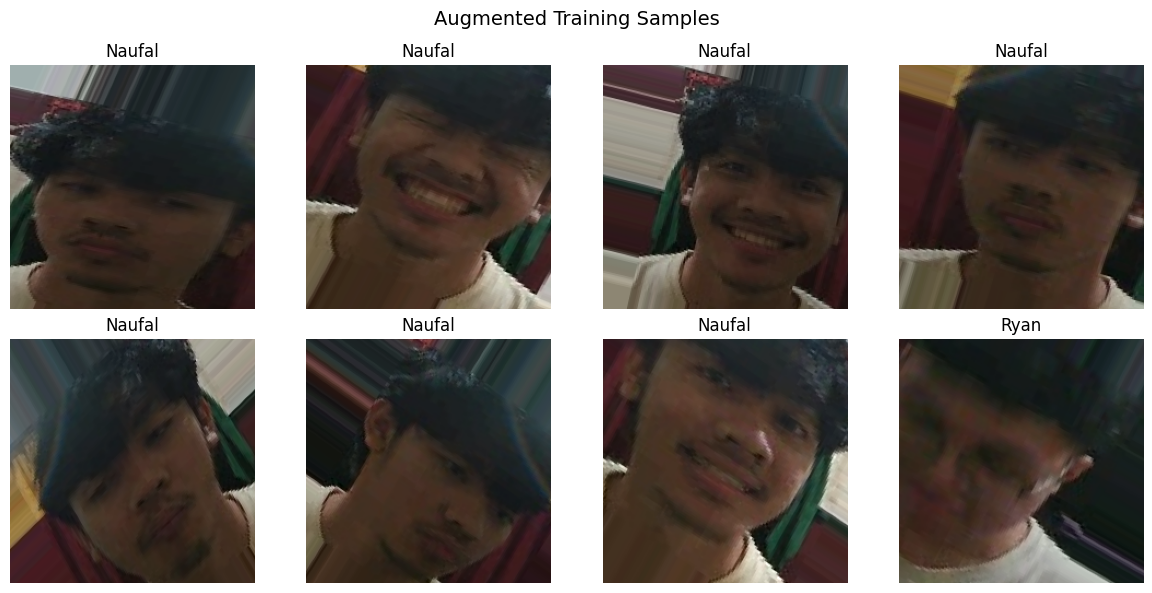

In [14]:
# ============================================
# CELL A3: Data Augmentation & Loading
# ============================================

# Strong data augmentation for small dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2  # 80% train, 20% validation
)

# Validation data (no augmentation except rescale)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary' if NUM_CLASSES == 2 else 'categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary' if NUM_CLASSES == 2 else 'categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Get class indices
class_names = list(train_generator.class_indices.keys())
print("=" * 60)
print("📊 Dataset Summary")
print("=" * 60)
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Classes: {class_names}")
print(f"   Class indices: {train_generator.class_indices}")

# Visualize augmented samples
print("\n🖼️ Visualizing Augmented Training Samples:")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
batch_images, batch_labels = next(train_generator)
for i, ax in enumerate(axes.flat):
    if i < len(batch_images):
        ax.imshow(batch_images[i])
        label_idx = int(batch_labels[i]) if NUM_CLASSES == 2 else np.argmax(batch_labels[i])
        ax.set_title(f"{class_names[label_idx]}")
        ax.axis('off')
plt.suptitle('Augmented Training Samples', fontsize=14)
plt.tight_layout()
plt.show()

# Reset generator
train_generator.reset()
val_generator.reset()

In [33]:
# ============================================
# CELL A4: Compile & Train (Frozen Base)
# ============================================

# Compile model
if NUM_CLASSES == 2:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
else:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'models/mobilenet_face_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Create models directory
os.makedirs('models', exist_ok=True)

print("=" * 60)
print("🚀 Phase 1: Training with Frozen Base (Transfer Learning)")
print("=" * 60)

# Calculate steps
steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
validation_steps = max(1, val_generator.samples // BATCH_SIZE)

# Train
history1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Phase 1 Training Complete!")
print(f"   Best Validation Accuracy: {max(history1.history['val_accuracy'])*100:.2f}%")

🚀 Phase 1: Training with Frozen Base (Transfer Learning)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.4663 - loss: 0.9902
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to models/mobilenet_face_best.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4698 - loss: 1.0021 - val_accuracy: 0.6250 - val_loss: 0.6362 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_accuracy improved from 0.62500 to 0.75000, saving model to models/mobilenet_face_best.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6438 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 951ms/step - accuracy: 0.5483 - loss: 0.8606 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.75000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.5865 - learning_rate: 1.0000e-04
Epoch 5/50
5/5 ━━━━━━━

In [34]:
# ============================================
# CELL A5: Fine-tuning (Unfreeze Top Layers)
# ============================================

print("=" * 60)
print("🔧 Phase 2: Fine-tuning Top Layers")
print("=" * 60)

# Unfreeze top 20 layers of base model
FINE_TUNE_LAYERS = 20

for layer in base_model.layers[-FINE_TUNE_LAYERS:]:
    layer.trainable = True

# Recompile with lower learning rate for fine-tuning
if NUM_CLASSES == 2:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
else:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# Update trainable count
trainable_params = sum([tf.reduce_prod(w.shape).numpy() for w in model.trainable_weights])
print(f"   Unfrozen Layers: {FINE_TUNE_LAYERS}")
print(f"   New Trainable Parameters: {trainable_params:,}")

# Updated callbacks for fine-tuning
callbacks_ft = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'models/mobilenet_face_finetuned.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

# Reset generators
train_generator.reset()
val_generator.reset()

# Fine-tune
history2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,  # Fewer epochs for fine-tuning
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_ft,
    verbose=1
)

print("\n✅ Phase 2 Fine-tuning Complete!")
print(f"   Best Validation Accuracy: {max(history2.history['val_accuracy'])*100:.2f}%")

🔧 Phase 2: Fine-tuning Top Layers
   Unfrozen Layers: 20
   New Trainable Parameters: 2,158,849
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7300 - loss: 0.5787
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to models/mobilenet_face_finetuned.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.7271 - loss: 0.5780 - val_accuracy: 0.8750 - val_loss: 0.3086 - learning_rate: 1.0000e-05
Epoch 2/30

Epoch 2: val_accuracy improved from 0.87500 to 1.00000, saving model to models/mobilenet_face_finetuned.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5641 - learning_rate: 1.0000e-05
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6280 - loss: 0.6591 - learning_rate: 1.0000e-05
Epoch 4/30

Epoch 4: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.3033 - lear

History 1 accuracy length: 32
History 1 val_accuracy length: 22
History 2 accuracy length: 17
History 2 val_accuracy length: 12


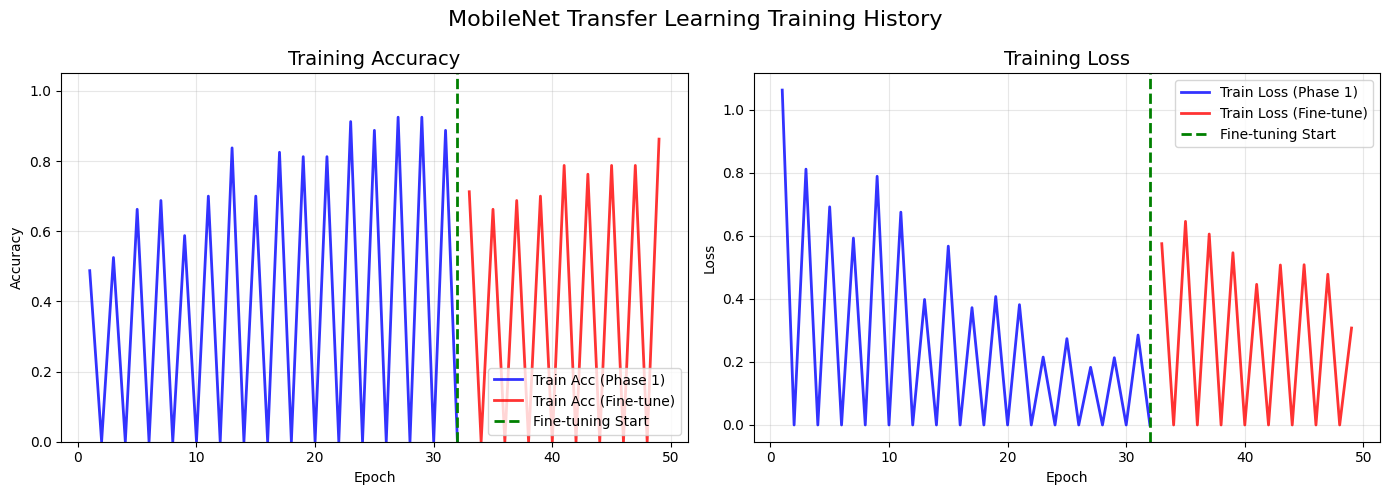

📈 Training Summary
   Phase 1 Epochs: 32
   Phase 2 Epochs: 17
   Phase 1 Best Train Accuracy: 92.50%
   Phase 2 Best Train Accuracy: 86.25%
   Final Train Accuracy: 86.25%


In [35]:
# ============================================
# CELL A6: Plot Training History
# ============================================

# Debug: check history lengths
print("History 1 accuracy length:", len(history1.history['accuracy']))
print("History 1 val_accuracy length:", len(history1.history['val_accuracy']))
print("History 2 accuracy length:", len(history2.history['accuracy']))
print("History 2 val_accuracy length:", len(history2.history['val_accuracy']))

# Use only train accuracy which should have consistent length
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Phase 1
epochs1 = range(1, len(history1.history['accuracy']) + 1)
axes[0].plot(epochs1, history1.history['accuracy'], 'b-', label='Train Acc (Phase 1)', linewidth=2, alpha=0.8)

# Phase 2
epochs2 = range(len(history1.history['accuracy']) + 1, 
                len(history1.history['accuracy']) + len(history2.history['accuracy']) + 1)
axes[0].plot(epochs2, history2.history['accuracy'], 'r-', label='Train Acc (Fine-tune)', linewidth=2, alpha=0.8)
axes[0].axvline(x=len(history1.history['accuracy']), color='g', linestyle='--', label='Fine-tuning Start', linewidth=2)

axes[0].set_title('Training Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Loss
axes[1].plot(epochs1, history1.history['loss'], 'b-', label='Train Loss (Phase 1)', linewidth=2, alpha=0.8)
axes[1].plot(epochs2, history2.history['loss'], 'r-', label='Train Loss (Fine-tune)', linewidth=2, alpha=0.8)
axes[1].axvline(x=len(history1.history['accuracy']), color='g', linestyle='--', label='Fine-tuning Start', linewidth=2)

axes[1].set_title('Training Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.suptitle('MobileNet Transfer Learning Training History', fontsize=16)
plt.tight_layout()
plt.savefig('models/mobilenet_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print best metrics
print("=" * 60)
print("📈 Training Summary")
print("=" * 60)
print(f"   Phase 1 Epochs: {len(history1.history['accuracy'])}")
print(f"   Phase 2 Epochs: {len(history2.history['accuracy'])}")
print(f"   Phase 1 Best Train Accuracy: {max(history1.history['accuracy'])*100:.2f}%")
print(f"   Phase 2 Best Train Accuracy: {max(history2.history['accuracy'])*100:.2f}%")
print(f"   Final Train Accuracy: {history2.history['accuracy'][-1]*100:.2f}%")

🔍 Evaluating model on validation set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step

📊 Classification Report
              precision    recall  f1-score   support

      Naufal       0.83      1.00      0.91        10
        Ryan       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



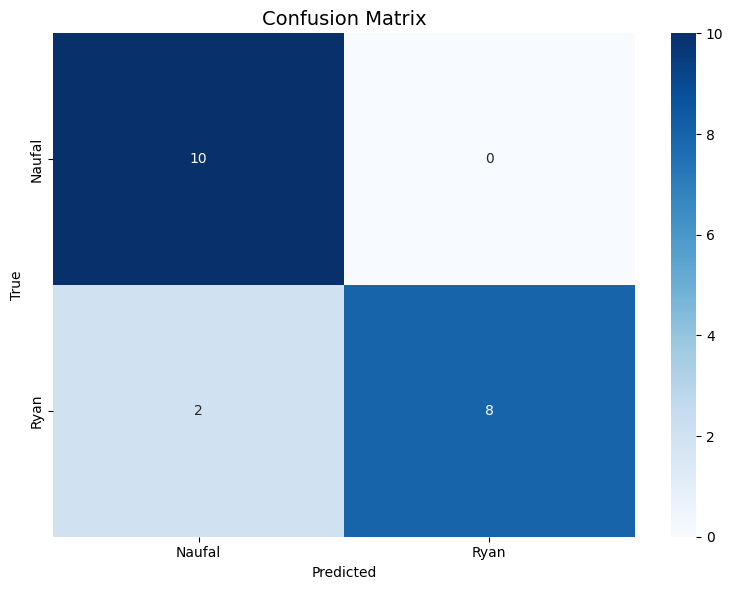


✅ Overall Validation Accuracy: 90.00%


In [36]:
# ============================================
# CELL A7: Evaluation & Confusion Matrix
# ============================================

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Reset generator for evaluation
val_generator.reset()

# Predict on validation set
print("🔍 Evaluating model on validation set...")
predictions = model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE + 1)

# Get true labels
y_true = val_generator.classes[:len(predictions)]
if NUM_CLASSES == 2:
    y_pred = (predictions.flatten() > 0.5).astype(int)
else:
    y_pred = np.argmax(predictions, axis=1)

# Make sure arrays are same length
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Classification report
print("\n" + "=" * 60)
print("📊 Classification Report")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title('Confusion Matrix', fontsize=14)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
plt.savefig('models/confusion_matrix.png', dpi=150)
plt.show()

# Overall accuracy
accuracy = np.sum(y_true == y_pred) / len(y_true)
print(f"\n✅ Overall Validation Accuracy: {accuracy*100:.2f}%")

🖼️ Visual Prediction Test


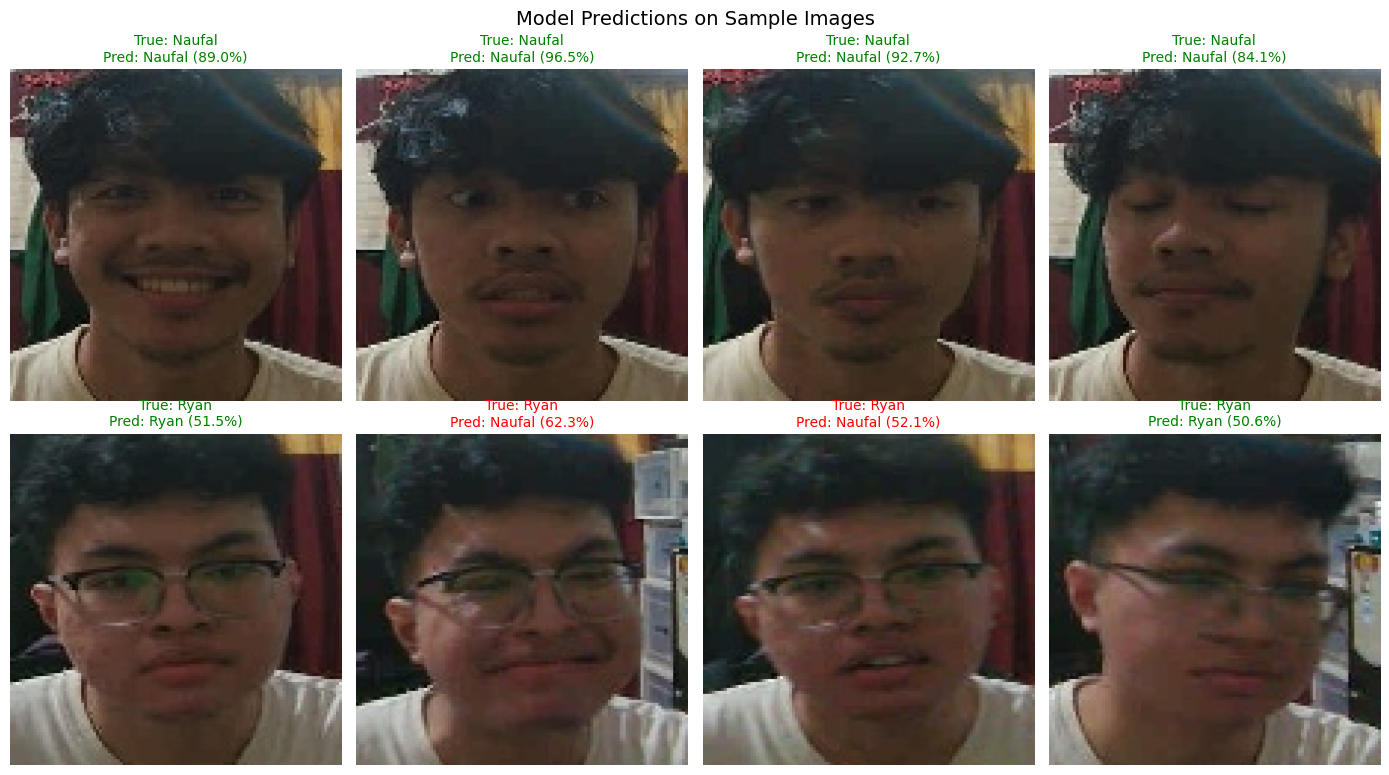

In [37]:
# ============================================
# CELL A8: Visual Test on Sample Images
# ============================================

def predict_single_image(model, image_path, class_names, img_size=224):
    """Predict and visualize single image."""
    from tensorflow.keras.preprocessing import image as keras_image
    
    # Load and preprocess
    img = keras_image.load_img(image_path, target_size=(img_size, img_size))
    img_array = keras_image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Predict
    pred = model.predict(img_batch, verbose=0)
    if len(class_names) == 2:
        confidence = pred[0][0]
        predicted_class = class_names[1] if confidence > 0.5 else class_names[0]
        confidence = confidence if confidence > 0.5 else 1 - confidence
    else:
        predicted_class = class_names[np.argmax(pred)]
        confidence = np.max(pred)
    
    return predicted_class, confidence, img

# Test on random samples from each class
print("=" * 60)
print("🖼️ Visual Prediction Test")
print("=" * 60)

fig, axes = plt.subplots(2, 4, figsize=(14, 8))

for row, class_name in enumerate(class_names):
    class_path = os.path.join(DATASET_PATH, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Select 4 random samples
    sample_images = np.random.choice(images, min(4, len(images)), replace=False)
    
    for col, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        pred_class, conf, img = predict_single_image(model, img_path, class_names, IMG_SIZE)
        
        ax = axes[row, col]
        ax.imshow(img)
        
        # Color based on correct/incorrect
        color = 'green' if pred_class == class_name else 'red'
        ax.set_title(f'True: {class_name}\nPred: {pred_class} ({conf*100:.1f}%)', 
                    color=color, fontsize=10)
        ax.axis('off')

plt.suptitle('Model Predictions on Sample Images', fontsize=14)
plt.tight_layout()
plt.savefig('models/prediction_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# ============================================
# CELL A9: Save & Convert to TFLite
# ============================================

print("=" * 60)
print("💾 Saving Models")
print("=" * 60)

# Save Keras model
model.save('models/mobilenet_face_final.keras')
print("✅ Saved: models/mobilenet_face_final.keras")

# Also save in H5 format for compatibility
model.save('models/mobilenet_face_final.h5')
print("✅ Saved: models/mobilenet_face_final.h5")

# Save class names
import json
with open('models/class_names.json', 'w') as f:
    json.dump({'class_names': class_names, 'class_indices': train_generator.class_indices}, f, indent=2)
print("✅ Saved: models/class_names.json")

print("\n" + "=" * 60)
print("📱 Converting to TFLite")
print("=" * 60)

# Convert to TFLite (Float32)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('models/mobilenet_face_float32.tflite', 'wb') as f:
    f.write(tflite_model)
print(f"✅ Float32 TFLite: {len(tflite_model) / 1024 / 1024:.2f} MB")

# Convert to TFLite (Float16 - smaller, minor accuracy loss)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model_fp16 = converter.convert()
with open('models/mobilenet_face_float16.tflite', 'wb') as f:
    f.write(tflite_model_fp16)
print(f"✅ Float16 TFLite: {len(tflite_model_fp16) / 1024 / 1024:.2f} MB")

# Convert to TFLite (INT8 Quantization - smallest, for mobile)
def representative_dataset():
    """Generate representative dataset for INT8 quantization."""
    for _ in range(100):
        # Generate random images similar to training data
        yield [np.random.randn(1, IMG_SIZE, IMG_SIZE, 3).astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

try:
    tflite_model_int8 = converter.convert()
    with open('models/mobilenet_face_int8.tflite', 'wb') as f:
        f.write(tflite_model_int8)
    print(f"✅ INT8 TFLite: {len(tflite_model_int8) / 1024 / 1024:.2f} MB")
except Exception as e:
    print(f"⚠️ INT8 conversion failed (using Float16 instead): {e}")

print("\n📦 All models saved in 'models/' folder!")

💾 Saving Models


✅ Saved: models/mobilenet_face_final.keras
✅ Saved: models/mobilenet_face_final.h5
✅ Saved: models/class_names.json

📱 Converting to TFLite
INFO:tensorflow:Assets written to: C:\Users\dzak\AppData\Local\Temp\tmp1ybpj31n\assets


INFO:tensorflow:Assets written to: C:\Users\dzak\AppData\Local\Temp\tmp1ybpj31n\assets


Saved artifact at 'C:\Users\dzak\AppData\Local\Temp\tmp1ybpj31n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_354')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1987072881872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072882640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072882448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072880720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987073622672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072882832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19

INFO:tensorflow:Assets written to: C:\Users\dzak\AppData\Local\Temp\tmpf9iegu5a\assets


Saved artifact at 'C:\Users\dzak\AppData\Local\Temp\tmpf9iegu5a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_354')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1987072881872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072882640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072882448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072880720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987073622672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072882832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19

INFO:tensorflow:Assets written to: C:\Users\dzak\AppData\Local\Temp\tmpdo0agj3l\assets


Saved artifact at 'C:\Users\dzak\AppData\Local\Temp\tmpdo0agj3l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_354')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1987072881872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072882640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072882448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072880720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987073622672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072883216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1987072882832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19

In [23]:
# ============================================
# CELL A10: Test TFLite Model
# ============================================

print("=" * 60)
print("🧪 Testing TFLite Model")
print("=" * 60)

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='models/mobilenet_face_float16.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"Input shape: {input_details[0]['shape']}")
print(f"Input dtype: {input_details[0]['dtype']}")
print(f"Output shape: {output_details[0]['shape']}")

def predict_tflite(interpreter, image_path, class_names, img_size=224):
    """Predict using TFLite model."""
    from tensorflow.keras.preprocessing import image as keras_image
    
    # Load and preprocess
    img = keras_image.load_img(image_path, target_size=(img_size, img_size))
    img_array = keras_image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0).astype(np.float32)
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], img_batch)
    
    # Run inference
    interpreter.invoke()
    
    # Get output
    output = interpreter.get_tensor(output_details[0]['index'])
    
    if len(class_names) == 2:
        confidence = output[0][0]
        predicted_class = class_names[1] if confidence > 0.5 else class_names[0]
        confidence = confidence if confidence > 0.5 else 1 - confidence
    else:
        predicted_class = class_names[np.argmax(output)]
        confidence = np.max(output)
    
    return predicted_class, float(confidence)

# Test on samples
print("\n🖼️ TFLite Predictions:")
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    images = os.listdir(class_path)
    if images:
        img_path = os.path.join(class_path, images[0])
        pred, conf = predict_tflite(interpreter, img_path, class_names, IMG_SIZE)
        status = "✅" if pred == class_name else "❌"
        print(f"   {status} {class_name}: Predicted '{pred}' ({conf*100:.1f}%)")

print("\n✅ TFLite model is ready for Android deployment!")

🧪 Testing TFLite Model
Input shape: [  1 224 224   3]
Input dtype: <class 'numpy.float32'>
Output shape: [1 1]

🖼️ TFLite Predictions:
   ✅ Naufal: Predicted 'Naufal' (80.6%)
   ✅ Ryan: Predicted 'Ryan' (57.9%)

✅ TFLite model is ready for Android deployment!
